# 天气最高温度预测任务

我们要完成三项任务：
- 使用随机森林算法完成基本建模任务

基本任务需要我们处理数据，观察特征，完成建模并进行可视化展示分析

- 观察数据量与特征个数对结果影响

在保证算法一致的前提下，加大数据个数，观察结果变换。重新考虑特征工程，引入新特征后观察结果走势。

- 对随机森林算法进行调参，找到最合适的参数

掌握机器学习中两种经典调参方法，对当前模型进行调节

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

import seaborn as sns

# 设置主题
sns.set_theme(style="ticks", color_codes=True);

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
features = pd.read_csv('data/temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


数据表中
* year,moth,day,week表示的具体的日期
* temp_2：当前日期前天的最高温度值
* temp_1：当前日期昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：这一列可能是凑热闹的，你的朋友猜测的可能值，咱们不管它就好了

# 数据大小

In [3]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 9)


结果显示：The shape of our features is: (348, 9)，表示我们的数据一共有348条记录，每个样本有9个特征。如果你想观察一下各个指标的统计特性，还可以用.describe()来直接展示一下：

In [4]:
# 统计指标
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.511494,62.560345,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,11.813019,11.767406,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,92.000000,92.000000,77.400000,92.000000,95.000000


其中包括了各个列的数量，如果有缺失数据，数量就有所减少，这里因为并不存在缺失值，所以各个列的数量值就都是348了，均值，标准差，最大最小值等指标在这里就都显示出来了。
对于时间数据，我们也可以进行一些转换，目的就是有些工具包在绘图或者计算的过程中，需要标准的时间格式：

In [5]:
# 处理时间数据
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# 把字符串转换成datetime对象
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [6]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

# 数据展示

In [7]:
# 指定风格
# plt.style.use('fivethirtyeight')

接着我们设计画图的布局，这里我们需要展示4项指标，分别为最高气温的标签值，前天，昨天，朋友预测的气温最高值。既然是4个图，那不妨使用2*2的规模来画，这样会更清晰一点，对每个图再指定好其名字和坐标轴含义就可以了：

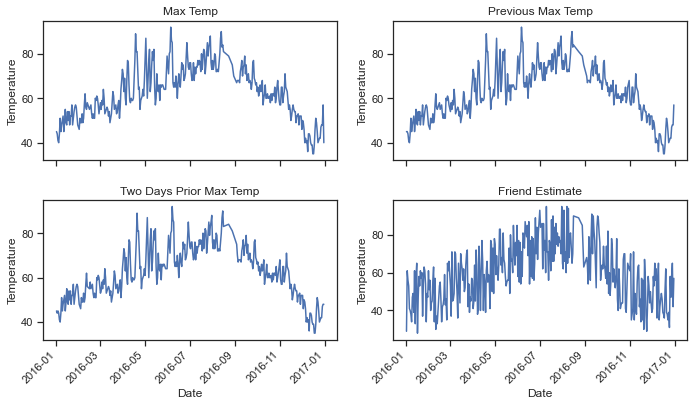

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,6))

# 旋转刻度
fig.autofmt_xdate(rotation = 45)

# 当天实际气温
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); 
ax1.set_ylabel('Temperature'); 
ax1.set_title('Max Temp')

# 当前日期昨天的气温
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); 
ax2.set_ylabel('Temperature'); 
ax2.set_title('Previous Max Temp')

# 当前日期前天的气温
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); 
ax3.set_ylabel('Temperature'); 
ax3.set_title('Two Days Prior Max Temp')

# 朋友的猜测值
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); 
ax4.set_ylabel('Temperature'); 
ax4.set_title('Friend Estimate')

# 调整子图之间的间距
plt.tight_layout(pad=2)

# 这里画图的目的是为了观察数据的分布情况，看看有没有异常的数据

各项指标看起来都还算正常，接下来就要考虑数据预处理问题了，注意原始数据中week这一列中并不是数值特征，而是表示周几的字符串，需要进行转换：

# 数据预处理


### One-Hot Encoding

原始数据：

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

编码转换后:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

In [9]:
# 把离散的特征值转换成独热编码形式
features = pd.get_dummies(features)
features.head()

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


这样就完成了数据集中属性值的预处理工作，默认会把所有属性值都转换成独热编码的格式，并且还帮我们自动添加了后缀看起来更清晰了，这里我们其实也可以按照自己的方式来设置编码特征的名字的，如果大家遇到了一个不太熟悉的函数，想看一下其中的细节，有一个更直接的方法就是在notebook当中直接调help工具来看一下它的API文档，不光有各个参数说明，还有一些小例子，建议大家在使用的过程中一定要养成多练多查的习惯，查找解决问题的方法也是一个很重要的技能

In [10]:
help(pd.get_dummies)

Help on function get_dummies in module pandas.core.reshape.reshape:

get_dummies(data, prefix=None, prefix_sep='_', dummy_na: 'bool' = False, columns=None, sparse: 'bool' = False, drop_first: 'bool' = False, dtype: 'Dtype | None' = None) -> 'DataFrame'
    Convert categorical variable into dummy/indicator variables.
    
    Parameters
    ----------
    data : array-like, Series, or DataFrame
        Data of which to get dummy indicators.
    prefix : str, list of str, or dict of str, default None
        String to append DataFrame column names.
        Pass a list with length equal to the number of columns
        when calling get_dummies on a DataFrame. Alternatively, `prefix`
        can be a dictionary mapping column names to prefixes.
    prefix_sep : str, default '_'
        If appending prefix, separator/delimiter to use. Or pass a
        list or dictionary as with `prefix`.
    dummy_na : bool, default False
        Add a column to indicate NaNs, if False NaNs are ignored.
  

In [11]:
print('Shape of features after one-hot encoding:', features.shape)

Shape of features after one-hot encoding: (348, 15)


### 标签与数据格式转换

In [12]:
# 样本的标签值
labels = np.array(features['actual'])

# 在特征中去掉标签这一列
features = features.drop('actual', axis=1)

# 保存列名
feature_list = list(features.columns)

# 转换成numpy格式
features = np.array(features)

### 训练集与测试集

In [13]:
# 数据集切分，注意树形模型不需要进行标准化，因此直接切分数据集
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [14]:
print('训练集特征:', train_features.shape)
print('训练集标签:', train_labels.shape)
print('测试集特征:', test_features.shape)
print('测试集标签:', test_labels.shape)

训练集特征: (261, 14)
训练集标签: (261,)
测试集特征: (87, 14)
测试集标签: (87,)


# 建立一个基础的随机森林模型
万事俱备，我们可以来建立随机森林模型啦，首先导入工具包，先建立1000个树试试吧，其他参数先用默认值，之后我们会再深入到调参任务中：

In [15]:
from sklearn.ensemble import RandomForestRegressor

# 设置子树数量为1000，不限制高度
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

由于数据量非常小，所以很快就可以得到结果了，这里我们使用MAPE指标来进行评估，也就是平均绝对百分误差，其实对于回归任务，评估方法还是比较多的，也可以选择其他指标来进行评估

MAPE计算公式如下:

<img src="1.png" width="200" height="200" align="left">

In [16]:
# 预测结果
predictions = rf.predict(test_features)

# 计算误差
errors = abs(predictions - test_labels)

# MAPE(mean absolute percentage error)平均绝对百分比误差
mape = 100 * (errors / test_labels)

print ('MAPE:',np.mean(mape))

MAPE: 6.011244187972058


# 可视化展示树

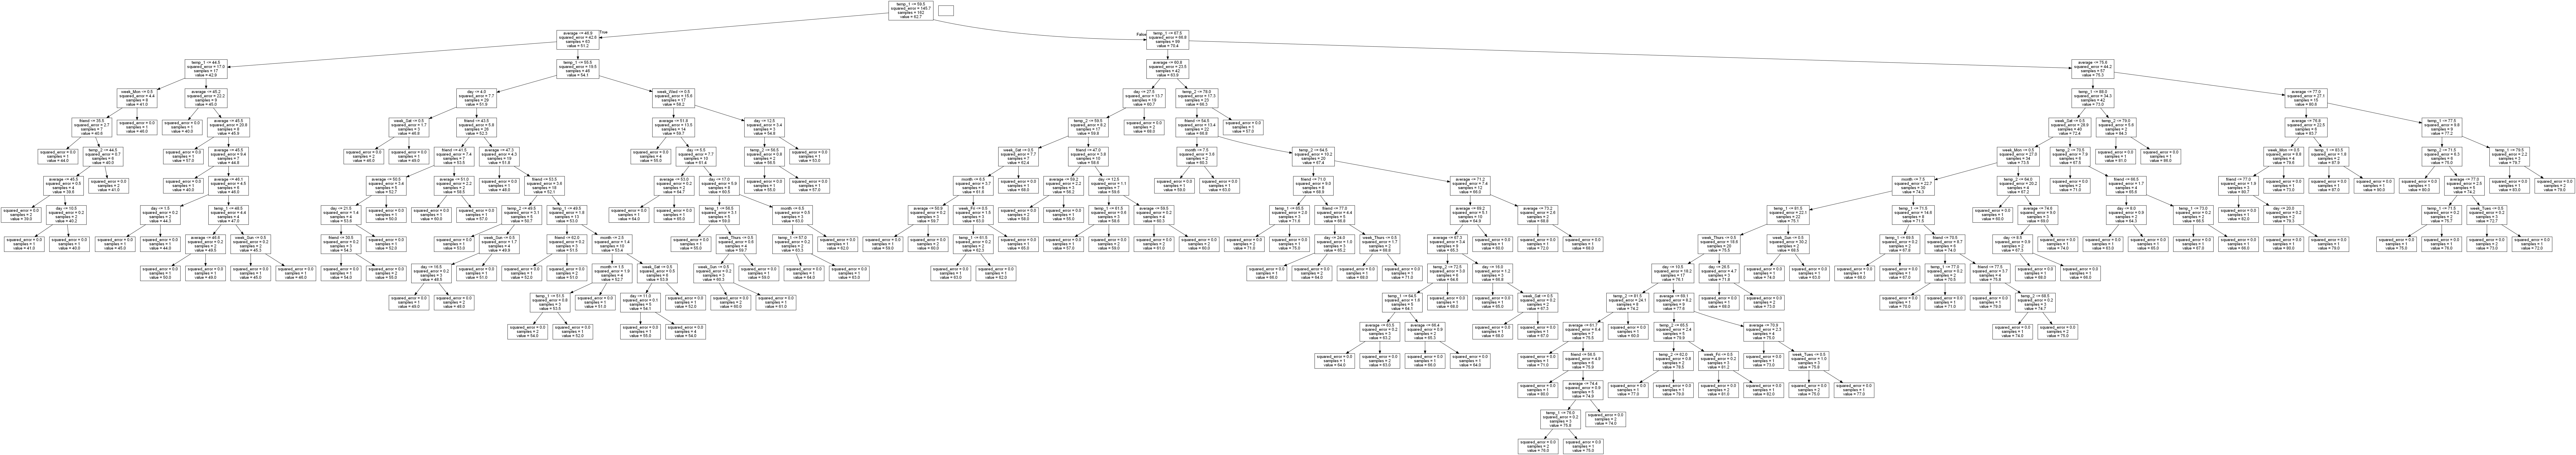

In [17]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image

# 拿到其中的一棵树(estimators_属性保存了随机森林中所有的决策树)
tree = rf.estimators_[5]

dot_data = export_graphviz(tree, feature_names = feature_list, precision = 1)

# 将图像保存到本地
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('full_tree.png'); 

# 如果想在notebook中展示图片，需要导入Image类
Image(graph.create_png())

In [18]:
# 树太高，看不清
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 15


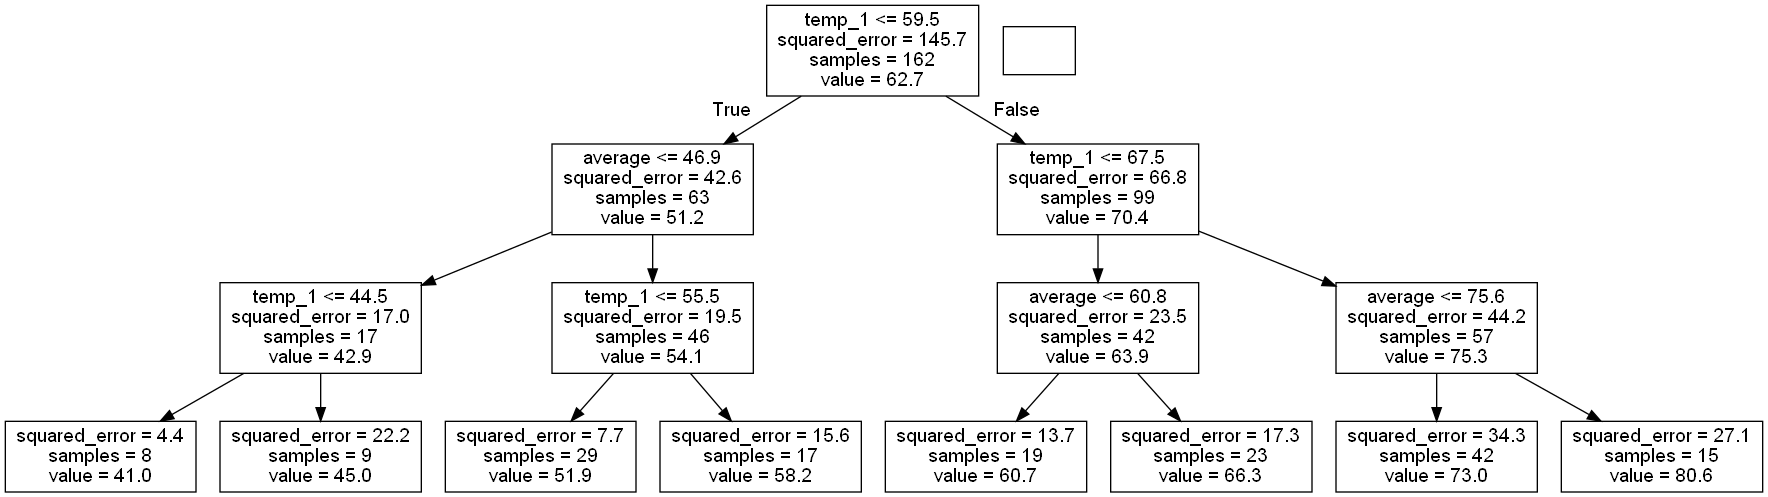

In [19]:
# 限制树的高度
rf_small = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
rf_small.fit(train_features, train_labels)

# 拿到其中一颗树
tree_small = rf_small.estimators_[5]

dot_data = export_graphviz(tree_small, feature_names=feature_list, precision = 1)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('small_tree.png');

# 如果想在notebook中展示图片，需要导入Image类
Image(graph.create_png())

# 根节点的62.7表示的是这个结点中的所有样本的平均值
# 即以后预测样本时，落到该集合的样本的预测值就是62.7

## Annotated Version of Tree

![Annotated Decision Tree](small_tree_annotated.PNG)

## 特征重要性

In [20]:
# 得到特征重要性
importances = list(rf.feature_importances_)

# 转换成元组类型，精确到两位小数
feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]

feature_importances

[('year', 0.0),
 ('month', 0.01),
 ('day', 0.03),
 ('temp_2', 0.02),
 ('temp_1', 0.7),
 ('average', 0.19),
 ('friend', 0.02),
 ('week_Fri', 0.0),
 ('week_Mon', 0.0),
 ('week_Sat', 0.0),
 ('week_Sun', 0.0),
 ('week_Thurs', 0.0),
 ('week_Tues', 0.0),
 ('week_Wed', 0.0)]

In [21]:
# 降序排序，比较的依据是元组下标为1的元素
# key参数的作用相当于java中的compareTo()方法
# 当然这里也可以转换成Series对象再进行排序会简单得多
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse=True)
feature_importances

[('temp_1', 0.7),
 ('average', 0.19),
 ('day', 0.03),
 ('temp_2', 0.02),
 ('friend', 0.02),
 ('month', 0.01),
 ('year', 0.0),
 ('week_Fri', 0.0),
 ('week_Mon', 0.0),
 ('week_Sat', 0.0),
 ('week_Sun', 0.0),
 ('week_Thurs', 0.0),
 ('week_Tues', 0.0),
 ('week_Wed', 0.0)]

In [22]:
# x_values是x轴坐标
x_values = list(range(len(importances)))
x_values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

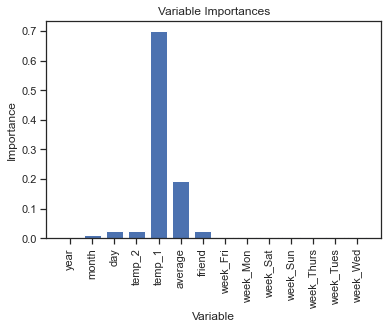

In [23]:
# 绘图展示
plt.bar(x_values, importances, tick_label=feature_list)

# 旋转x轴的标签
plt.xticks(rotation='vertical')

plt.ylabel('Importance'); 
plt.xlabel('Variable'); 
plt.title('Variable Importances'); 

### 用最重要的特征再来试试

In [24]:
# 选择最重要的那两个特征来试一试
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# 拿到这两个特征的下标
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]

train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# 重新训练模型
rf_most_important.fit(train_important, train_labels)

# 预测结果
predictions = rf_most_important.predict(test_important)

# 评估结果
errors = abs(predictions - test_labels)
mape = np.mean(100 * (errors / test_labels))
print('mape:', mape)

# 损失值比之前大了一点，但是由于这里只用了两个特征
# 因此模型训练速度更快，因此在准确率和训练速度之间存在权衡

mape: 6.229055723613811


### 观察预测值与真实值之间的差异

In [25]:
# 测试集的日期数据
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# 转换成datetime对象
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) 
         for year, month, day in zip(years, months, days)]

dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

dates[:5]

[datetime.datetime(2016, 9, 29, 0, 0),
 datetime.datetime(2016, 4, 27, 0, 0),
 datetime.datetime(2016, 11, 28, 0, 0),
 datetime.datetime(2016, 10, 12, 0, 0),
 datetime.datetime(2016, 6, 19, 0, 0)]

In [26]:
# 创建一个df对象保存真实数据和预测数据
data = pd.DataFrame({'date': dates, 
                     'actual': test_labels, "prediction": predictions})

data

,date,actual,prediction
0,2016-09-29,66,68.761500
1,2016-04-27,61,61.317000
2,2016-11-28,52,53.033000
3,2016-10-12,66,63.463000
4,2016-06-19,70,65.626000
...,...,...,...
82,2016-06-04,81,74.703000
83,2016-06-17,67,70.457000
84,2016-10-05,66,64.908000
85,2016-03-04,57,59.705000


In [27]:
# 按照date这一列排序
data.sort_values(by="date", inplace=True)
data

,date,actual,prediction
51,2016-01-04,40,42.813750
43,2016-01-06,51,41.601000
76,2016-01-08,48,41.907000
27,2016-01-10,52,46.721000
73,2016-01-17,50,47.990000
...,...,...,...
12,2016-12-10,44,38.169570
39,2016-12-20,51,43.329083
50,2016-12-21,49,47.915333
86,2016-12-22,45,49.285333


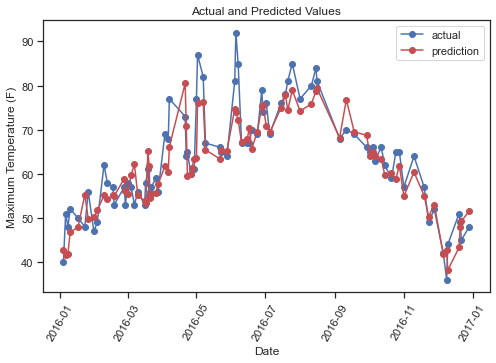

In [28]:
plt.figure(figsize=(8, 5))

# 真实值
plt.plot(data['date'], data['actual'], 'bo-', label = 'actual')

# 预测值
plt.plot(data['date'], data['prediction'], 'ro-', label = 'prediction')

plt.xticks(rotation='60'); 
plt.legend();
plt.xlabel('Date'); 
plt.ylabel('Maximum Temperature (F)'); 
plt.title('Actual and Predicted Values');

可以看到预测值和真实值的趋势基本相同，那么接下来我们要再深入到数据中了，考虑几个问题：
1.如果可以利用的数据量增大，会对结果产生什么影响呢？
2.加入新的特征会改进模型效果吗？此时的时间效率又会怎样？

# 更多的数据效果会不会更好呢？


In [29]:
# 读入新的数据，现在这份新的数据样本数和特征数都比原来的数据多
# 之前是只包括2016年的数据，现在包括2011到2016年的数据
features = pd.read_csv('data/temps_extended.csv')
features.head(5)

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39


数据规模 (2191, 12)

新的数据中，数据规模发生了变化，数据量扩充到了2191条并且加入了新的天气指标：

* ws_1：前一天的风速
* prcp_1: 前一天的降水
* snwd_1：前一天的积雪深度

既然有了新的特征，先来看看他们长什么样吧，同样的方式绘制就可以了：

In [30]:
print('数据规模', features.shape)

数据规模 (2191, 12)


## 统计指标

In [31]:
# 只显示到两位小数
round(features.describe(), 2)

,year,month,day,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
count,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00
mean,2013.50,6.52,15.71,7.37,0.12,0.01,61.17,61.18,60.29,61.18,60.31
std,1.71,3.45,8.80,3.15,0.25,0.15,13.09,13.08,10.73,13.08,15.87
min,2011.00,1.00,1.00,0.89,0.00,0.00,29.00,29.00,45.10,29.00,25.00
25%,2012.00,4.00,8.00,5.14,0.00,0.00,51.00,51.00,50.10,51.00,49.00
50%,2014.00,7.00,16.00,6.71,0.00,0.00,60.00,60.00,58.80,60.00,60.00
75%,2015.00,10.00,23.00,9.17,0.12,0.00,71.00,71.00,70.20,71.00,71.00
max,2017.00,12.00,31.00,21.25,2.20,3.00,96.00,96.00,77.40,96.00,97.00


In [32]:
# 得到各种日期数据
years = features['year']
months = features['month']
days = features['day']

# 转换成datetime对象
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) 
         for year, month, day in zip(years, months, days)]

dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

dates[:5]

[datetime.datetime(2011, 1, 1, 0, 0),
 datetime.datetime(2011, 1, 2, 0, 0),
 datetime.datetime(2011, 1, 3, 0, 0),
 datetime.datetime(2011, 1, 4, 0, 0),
 datetime.datetime(2011, 1, 5, 0, 0)]

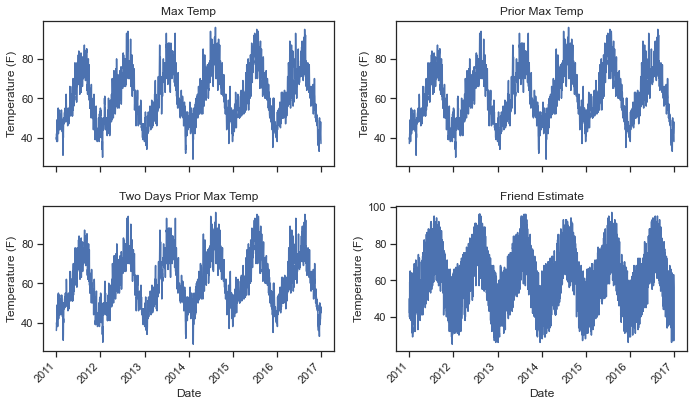

In [33]:
# 观察数据分布

# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10, 6))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); 
ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature (F)'); 
ax2.set_title('Prior Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature (F)'); 
ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature (F)'); 
ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

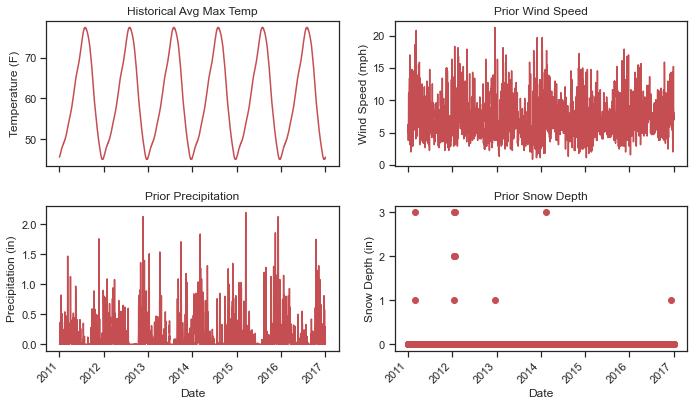

In [34]:
# 设置整体布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10, 6))
fig.autofmt_xdate(rotation = 45)

# 平均最高气温
ax1.plot(dates, features['average'], "r-")
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); 
ax1.set_title('Historical Avg Max Temp')

# 风速
ax2.plot(dates, features['ws_1'], 'r-')
ax2.set_xlabel(''); ax2.set_ylabel('Wind Speed (mph)'); 
ax2.set_title('Prior Wind Speed')

# 降水
ax3.plot(dates, features['prcp_1'], 'r-')
ax3.set_xlabel('Date'); ax3.set_ylabel('Precipitation (in)'); 
ax3.set_title('Prior Precipitation')

# 积雪
ax4.plot(dates, features['snwd_1'], 'ro')
ax4.set_xlabel('Date'); ax4.set_ylabel('Snow Depth (in)'); 
ax4.set_title('Prior Snow Depth')

plt.tight_layout(pad=2)

在数据分析和特征提取的过程中，我们的出发点都是尽可能多的选择有价值的特征，因为初始阶段我们能得到的信息越多，建模时可以利用的信息也就越多，比如在这份数据中，我们有完整日期数据，但是显示天气的变换肯定是跟季节因素有关的，但是在原始数据集中并没有体现出季节的指标，我们可以自己创建一个季节变量当做新的特征，无论是对之后建模还是分析都会起到帮助的，有了季节特征，假如我想观察一下不同季节上述各项指标的变换情况，该怎么做呢？这里给大家推荐一个非常实用的绘图函数pairplot，需要我们先安装seaborn这个工具包，它相当于是在matplotlib的基础上进行封装，说白了就是用起来更简单规范了：

## pairplot

In [35]:
# 创建一个季节变量
seasons = []

for month in features['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')

# 现在我们只选择'temp_1', 'prcp_1', 'average', 'actual'这四列特征
reduced_features = features[['temp_1', 'prcp_1', 'average', 'actual']]

reduced_features

,temp_1,prcp_1,average,actual
0,37,0.00,45.6,40
1,40,0.00,45.7,39
2,39,0.00,45.8,42
3,42,0.00,45.9,38
4,38,0.03,46.0,45
...,...,...,...,...
2186,44,0.05,45.3,47
2187,47,0.00,45.3,48
2188,48,0.05,45.4,45
2189,45,0.02,45.5,38


In [36]:
# 为数据添加季节这一列
reduced_features['season'] = seasons

reduced_features

,temp_1,prcp_1,average,actual,season
0,37,0.00,45.6,40,winter
1,40,0.00,45.7,39,winter
2,39,0.00,45.8,42,winter
3,42,0.00,45.9,38,winter
4,38,0.03,46.0,45,winter
...,...,...,...,...,...
2186,44,0.05,45.3,47,winter
2187,47,0.00,45.3,48,winter
2188,48,0.05,45.4,45,winter
2189,45,0.02,45.5,38,winter


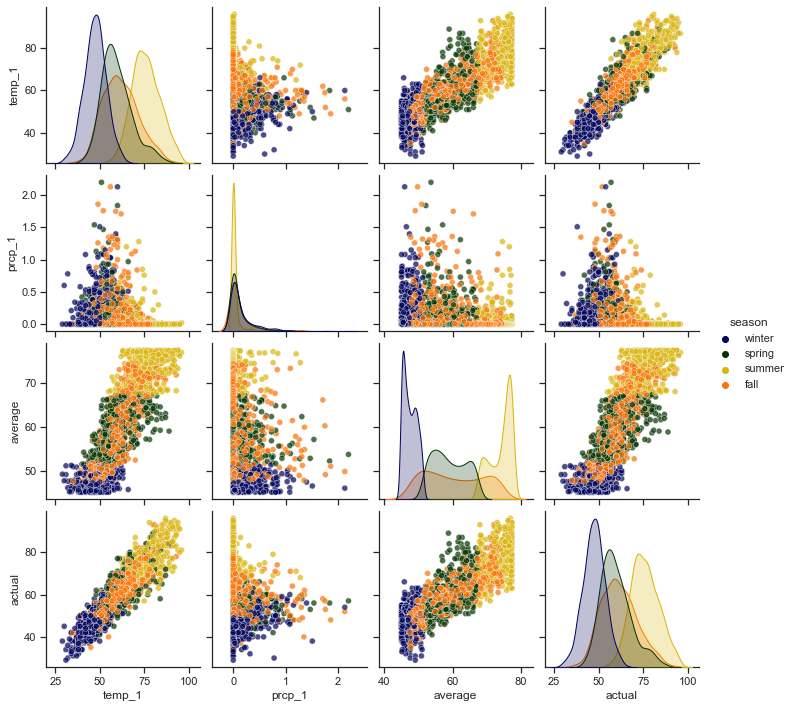

In [37]:
import seaborn as sns

# 设置主题
sns.set_theme(style="ticks", color_codes=True);

# 选择颜色模板
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

# hue指定划分不同样本点的特征
sns.pairplot(reduced_features, hue='season', diag_kind = 'kde', 
             palette= palette, plot_kws=dict(alpha = 0.7), diag_kws=dict(shade=True)); 

可以看到，x轴和y轴是这4项指标，不同颜色的点表示不同的季节，主对角线上(即左上角到右下角的这条线)的子图表示在不同季节下数值的分布情况(以右下角这个子图为例，对于winter这条蓝色的线，气温为50的天数大概有70天)，其他位置用散点图来表示两个特征之间的相关性，例如在左下角temp_1和actual就呈现出了很强的相关性，使用pairplot()绘图主要是为了观察特征与标签的关系(即上图的最后一行子图)

## 下面开始进行对比，数据预处理

In [38]:
# 独热编码
features = pd.get_dummies(features)

# 提取特征和标签
labels = features['actual']
features = features.drop('actual', axis = 1)

# 特征名
feature_list = list(features.columns)

# 转换成numpy数组
features = np.array(features)
labels = np.array(labels)

# 数据集切分
train_features, test_features, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [39]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1643, 17)
Training Labels Shape: (1643,)
Testing Features Shape: (548, 17)
Testing Labels Shape: (548,)


新的训练集由1643个样本组成，测试集有548个样本，总共17个特征

## 原来那份数据的结果

In [40]:
# feature_list保存的是完整的17个特征
# 现在提取出原来的14个特征的下标，不包括新的那3个特征
original_feature_indices = [feature_list.index(feature) 
    for feature in feature_list if feature not in ['ws_1', 'prcp_1', 'snwd_1']]

original_feature_indices

[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [41]:
# 读取原来的数据集，即数据样本少，特征也少的那份数据
original_features = pd.read_csv('data/temps.csv')

original_features

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41
...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,47
344,2016,12,28,Wed,42,47,45.3,48,58
345,2016,12,29,Thurs,47,48,45.3,48,65
346,2016,12,30,Fri,48,48,45.4,57,42


In [42]:
# 和之前一样的操作

# 独热编码
original_features = pd.get_dummies(original_features)

# 数据和标签转换
original_labels = np.array(original_features['actual'])

original_features= original_features.drop('actual', axis = 1)

# 特征名
original_feature_list = list(original_features.columns)

# 转换成numpy数组
original_features = np.array(original_features)

# 划分数据
original_train_features, original_test_features, \
original_train_labels, original_test_labels = \
    train_test_split(original_features, original_labels, 
                 test_size = 0.25, random_state = 42)

In [43]:
# 使用同样的树模型进行建模
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# 这里的训练集使用的是原来的数据集(即只有348个样本，14个特征的数据集)
rf.fit(original_train_features, original_train_labels);

# 为了保证测试公平，必须使用相同的测试集，
# 即统一使用刚刚切分得到的新数据集的测试集
# 但新数据集有17个特征，这里我们只选择原来的14个
predictions = rf.predict(test_features[:,original_feature_indices])

# 先计算温度平均误差
errors = abs(predictions - test_labels)

print('平均温度误差:', round(np.mean(errors), 2), 'degrees')

# MAPE
mape = np.mean(100 * (errors / test_labels))

# 这里的Accuracy只是为了方便观察，用100减去mape值，Accuracy越大越好
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%')

平均温度误差: 4.62 degrees
Accuracy: 92.29 %


原始数据集样本少，特征少，因此误差较大(注意这里的MAPE值不能拿去和一开始得到的那个6.0的MAPE值去比，因为虽然两个随机森林使用的训练集一样，但是测试集是不一样的！)

## 现在使用新的数据集，但只增大数据量，不使用新特征

In [44]:
# train_features和test_features是从新数据集中划分出来的训练集和测试集
# 剔除掉新的特征，保证数据特征是一致的
new_train_features = train_features[:, original_feature_indices]

new_test_features = test_features[:, original_feature_indices]

rf = RandomForestRegressor(n_estimators=1000 ,random_state=42)

rf.fit(new_train_features, train_labels);

# 预测
baseline_predictions = rf.predict(new_test_features)

baseline_errors = abs(baseline_predictions - test_labels)
print('平均温度误差:', round(np.mean(baseline_errors), 2), 'degrees')

# MAPE
baseline_mape = 100 * np.mean((baseline_errors / test_labels))

baseline_accuracy = 100 - baseline_mape
print('Accuracy:', round(baseline_accuracy, 2), '%')

平均温度误差: 4.17 degrees
Accuracy: 93.17 %


可以看到，把数据量增大之后，即使不使用新的特征，效果也有一定的提升，这也符合实际情况，在机器学习任务中，我们都是希望数据量越大越好，这样可利用的信息就更多，下面再对比一下特征数量对结果的影响，这两次比较还没有加入新的特征，这回把降水，风速，积雪3特征加入训练集中，看看效果又会怎样：

## 加入新特征

In [45]:
rf_exp = RandomForestRegressor(n_estimators=1000, random_state=42)

# 因为使用了新特征，这里就直接使用新的数据集
rf_exp.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [46]:
# 同样的测试集
predictions = rf_exp.predict(test_features)

errors = abs(predictions - test_labels)
print('平均温度误差:', round(np.mean(errors), 2), 'degrees')

# MAPE
mape = np.mean(100 * (errors / test_labels))

# 看一下提升了多少
improvement_baseline = 100 * abs(mape - baseline_mape) / baseline_mape
print('特征增多后模型效果提升:', round(improvement_baseline, 2), '%')

accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%')

平均温度误差: 4.04 degrees
特征增多后模型效果提升: 3.21 %
Accuracy: 93.39 %


效果又有了略微提升，这里我们还加入一项额外的评估就是模型跟基础模型相比提升的大小，方便进行对比观察。现在特征变多了，我们需要研究一下特征重要性这个指标

## 特征重要性

In [47]:
importances = list(rf_exp.feature_importances_)

# 名字，数值组合在一起
feature_importances = [(feature, round(importance, 2)) 
                    for feature, importance in zip(feature_list, importances)]

# 降序排序
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_importances

[('temp_1', 0.84),
 ('average', 0.06),
 ('ws_1', 0.02),
 ('friend', 0.02),
 ('year', 0.01),
 ('month', 0.01),
 ('day', 0.01),
 ('prcp_1', 0.01),
 ('temp_2', 0.01),
 ('snwd_1', 0.0),
 ('weekday_Fri', 0.0),
 ('weekday_Mon', 0.0),
 ('weekday_Sat', 0.0),
 ('weekday_Sun', 0.0),
 ('weekday_Thurs', 0.0),
 ('weekday_Tues', 0.0),
 ('weekday_Wed', 0.0)]

## Visualize Feature Importances

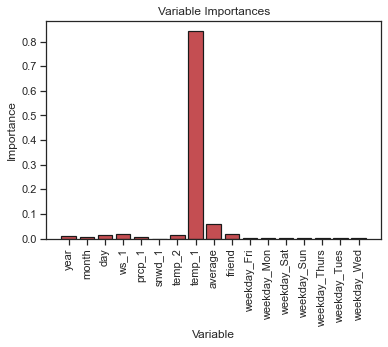

In [48]:
# x轴的标签
x_values = list(range(len(importances)))

plt.bar(x_values, importances, color = 'r', edgecolor = 'k', linewidth=1.2)

# 旋转x轴的标签
plt.xticks(x_values, feature_list, rotation='vertical')

plt.ylabel('Importance'); 
plt.xlabel('Variable'); 
plt.title('Variable Importances');

这里只是看到了在单一的特征中哪个最重要，现在我们需要考虑特征的累加重要性，即先把特征按照其重要性进行排序，再计算累计值，这里用到了cumsum()函数，比如cumsum([1,2,3,4])得到的结果就是其累加值(1,3,6,10)，通常以95%为阈值，即从最重要的特征开始选，有多少个特征累加在一起之后，其特征重要性的累加值超过阈值，就取它们当做筛选后的特征：

## 特征重要性累加，看看95%之前有多少个

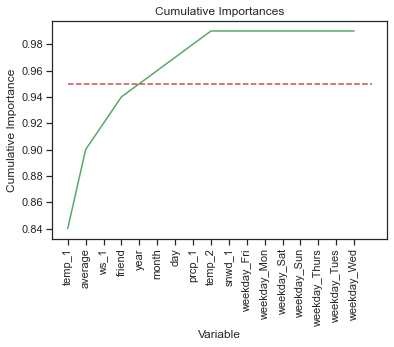

In [49]:
# 取出重要性的值
sorted_importances = [importance[1] for importance in feature_importances]

# 对应的标签值
sorted_features = [importance[0] for importance in feature_importances]

# 累计重要性
cumulative_importances = np.cumsum(sorted_importances)

# 绘制折线图
plt.plot(x_values, cumulative_importances, 'g-')

# 画一条0.95的红色虚线
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), 
           color = 'r', linestyles = 'dashed')

# X轴标签，旋转90°
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Y轴和名字
plt.xlabel('Variable'); 
plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Importances');

累加到第6个特征时，总体的累加值达到95%，那么接下来我们的对比实验又来了，如果只用这6个特征效果会怎么样呢？时间效率又会怎样呢？

## 把他们列出来吧！

In [50]:
# 一共使用6个特征，累计值超过95%
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 6


## 训练集和测试集要使用一样的

In [51]:
# 选择这些特征
important_feature_names = [feature[0] for feature in feature_importances[0:6]]

important_feature_names

['temp_1', 'average', 'ws_1', 'friend', 'year', 'month']

In [52]:
# 拿到下标
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# 现在只使用6个特征的数据训练，但测试集和之前一样
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]

print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (1643, 6)
Important test features shape: (548, 6)


In [53]:
# 再训练模型
rf_exp.fit(important_train_features, train_labels);

# 同样的测试集
predictions = rf_exp.predict(important_test_features)

# 评估结果
errors = abs(predictions - test_labels)
print('平均温度误差:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / test_labels)

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

平均温度误差: 4.08 degrees.
Accuracy: 93.35 %.


效果反而下降了，其实随机森林算法本身就会考虑特征的问题，会优先选择有价值的，我们认为的去掉一些，相当于可供候选的就少了，出现这样的现象在随机森林中并不奇怪！

## 计算Trade-Offs

看起来奇迹并没有出现，本以为效果反而会更好，其实还有一点点下降，这里可能是由于树模型本身就具有特征选择的功能。虽然模型没有提升，但可以看看在时间效率上有没有进步呢：

In [54]:
import time

# 这回使用所有特征
all_features_time = []

# 算一次可能不太准，计算10次取平均
for _ in range(10):
    start_time = time.time()
    
    # 训练+预测的时间(使用全部特征)
    rf_exp.fit(train_features, train_labels)
    all_features_predictions = rf_exp.predict(test_features)
    
    end_time = time.time()
    
    # 保存每次计算的结果
    all_features_time.append(end_time - start_time)

# 取平均值
all_features_time = np.mean(all_features_time)
print('使用所有特征时建模与测试的平均时间消耗:', round(all_features_time, 2), '秒.')

使用所有特征时建模与测试的平均时间消耗: 4.85 秒.


当我们使用全部特征的时候，建模与测试用的总时间为5秒，这里会由于机器性能导致咱们的速度不一样，大家在笔记本中估计运行时间要比我的稍长一点。再来看看只选择高重要性特征的时间：

In [55]:
# 这回使用部分重要的特征
reduced_features_time = []

for _ in range(10):
    start_time = time.time()
    
    # 只使用6个最重要的特征
    rf_exp.fit(important_train_features, train_labels)
    reduced_features_predictions = rf_exp.predict(important_test_features)
    
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)

reduced_features_time = np.mean(reduced_features_time)
print('使用所有特征时建模与测试的平均时间消耗:', round(reduced_features_time, 2), '秒.')

使用所有特征时建模与测试的平均时间消耗: 3.18 秒.


## Accuracy vs Run-Time

In [56]:
# 用得到的预测值来计算评估结果
all_accuracy =  100 * (1- np.mean(
    abs(all_features_predictions - test_labels) / test_labels))

reduced_accuracy = 100 * (1- np.mean(
    abs(reduced_features_predictions - test_labels) / test_labels))

# 创建一个df来保存结果
comparison = pd.DataFrame({'features': ['all (17)', 'reduced (6)'], 
    'run_time': [round(all_features_time, 2), round(reduced_features_time, 2)],
    'accuracy': [round(all_accuracy, 2), round(reduced_accuracy, 2)]})

comparison[['features', 'accuracy', 'run_time']]

,features,accuracy,run_time
0,all (17),93.39,4.85
1,reduced (6),93.35,3.18


In [57]:
relative_accuracy_decrease = 100 * (all_accuracy - reduced_accuracy) / all_accuracy
print('相对accuracy下降:', round(relative_accuracy_decrease, 3), '%.')

relative_runtime_decrease = 100 * (all_features_time - reduced_features_time) / all_features_time
print('相对时间效率提升:', round(relative_runtime_decrease, 3), '%.')

相对accuracy下降: 0.037 %.
相对时间效率提升: 34.347 %.


通常我们买东西都会考虑性价比，这里同样也是这个问题，时间效率的提升相对更大一些，而且基本保证了模型效果是差不多的。
最后把所有的实验结果汇总到一起来进行对比吧：

In [58]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
original_features = pd.read_csv('data/temps.csv')
original_features = pd.get_dummies(original_features)

# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
original_labels = np.array(original_features['actual'])

# Remove the labels from the features
# axis 1 refers to the columns
original_features= original_features.drop('actual', axis = 1)

# Saving feature names for later use
original_feature_list = list(original_features.columns)

# Convert to numpy array
original_features = np.array(original_features)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
original_train_features, original_test_features, \
original_train_labels, original_test_labels = \
    train_test_split(original_features, original_labels, 
                 test_size = 0.25, random_state = 42)

In [59]:
# Find the original feature indices 
original_feature_indices = [feature_list.index(feature) for feature in
                                      feature_list if feature not in
                                      ['ws_1', 'prcp_1', 'snwd_1']]

# Create a test set of the original features
original_test_features = test_features[:, original_feature_indices]

# Time to train on original data set (1 year)
original_features_time = []

# Do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    rf.fit(original_train_features, original_train_labels)
    original_features_predictions = rf.predict(original_test_features)
    end_time = time.time()
    original_features_time.append(end_time - start_time)
    
original_features_time = np.mean(original_features_time)

In [60]:
# Calculate mean absolute error for each model
original_mae = np.mean(abs(original_features_predictions - test_labels))
exp_all_mae = np.mean(abs(all_features_predictions - test_labels))
exp_reduced_mae = np.mean(abs(reduced_features_predictions - test_labels))

# Calculate accuracy for model trained on 1 year of data
original_accuracy = 100 * (1 - np.mean(
    abs(original_features_predictions - test_labels) / test_labels))

# Create a dataframe for comparison
model_comparison = pd.DataFrame({'model': ['original', 'exp_all', 'exp_reduced'], 
    'error (degrees)':  [original_mae, exp_all_mae, exp_reduced_mae],
    'accuracy': [original_accuracy, all_accuracy, reduced_accuracy],
    'run_time (s)': [original_features_time, all_features_time, reduced_features_time]})

# Order the dataframe
model_comparison = model_comparison[['model', 'error (degrees)', 'accuracy', 'run_time (s)']]

In [61]:
model_comparison

,model,error (degrees),accuracy,run_time (s)
0,original,4.621887,92.287943,1.153201
1,exp_all,4.035423,93.388480,4.851008
2,exp_reduced,4.075097,93.353551,3.184809


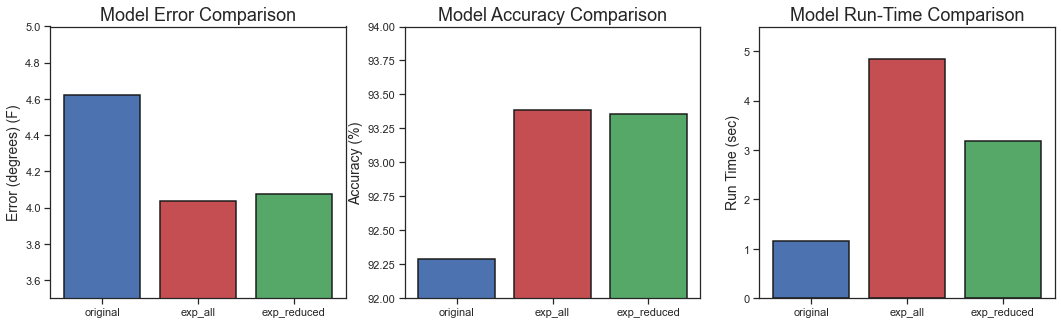

In [62]:
# 绘图来总结，sharex表示所有子图共享x轴的标签
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (18, 5), sharex = True)

# X轴标签
x_values = [0, 1, 2]
labels = list(model_comparison['model'])
plt.xticks(x_values, labels)

# 字体大小
fontdict = {'fontsize': 18}
fontdict_yaxis = {'fontsize': 14}

# 预测温度和真实温度差异对比
ax1.bar(x_values, model_comparison['error (degrees)'], 
        color = ['b', 'r', 'g'], edgecolor = 'k', linewidth = 1.5)
ax1.set_ylim(bottom = 3.5, top = 5)
ax1.set_ylabel('Error (degrees) (F)', fontdict = fontdict_yaxis); 
ax1.set_title('Model Error Comparison', fontdict= fontdict)

# Accuracy 对比
ax2.bar(x_values, model_comparison['accuracy'], 
        color = ['b', 'r', 'g'], edgecolor = 'k', linewidth = 1.5)
ax2.set_ylim(bottom = 92, top = 94)
ax2.set_ylabel('Accuracy (%)', fontdict = fontdict_yaxis); 
ax2.set_title('Model Accuracy Comparison', fontdict= fontdict)

# 时间效率对比
ax3.bar(x_values, model_comparison['run_time (s)'], 
        color = ['b', 'r', 'g'], edgecolor = 'k', linewidth = 1.5)
ax3.set_ylim(bottom = 0, top = 5.5)
ax3.set_ylabel('Run Time (sec)', fontdict = fontdict_yaxis); 
ax3.set_title('Model Run-Time Comparison', fontdict= fontdict);


original代表老数据，也就是量少特征少的那份；exp_all代表我们的完整新数据；exp_reduced代表我们按照95%阈值选择的部分重要特征数据集。结果也是很明显的，数据量和特征越多，效果会提升一些，但是时间效率也会有所下降